**Setup:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data/Inflation_Dataset_v1.csv')
# data.columns = [col.strip() for col in data.columns]# Clean column names
data = data.rename(columns={# rename columns
    'Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]': 'Inflation',
    'Broad money growth (annual %) [FM.LBL.BMNY.ZG]': 'Broad_Money_Growth',
    'Crude oil, Brent %': 'Crude_Oil_Brent',
    'Food imports (% of merchandise imports) ': 'Food_Imports_Pct',
    'OBS_VALUE(REER)': 'REER'
})
data_clean = data.dropna()

*Using* Inflation as dependent variable and other economic variables as predictors. This fits the context as inflation is often influenced by these other factors.

In [51]:
# Convert years to numeric if they're not already
data_clean['Time'] = pd.to_numeric(data_clean['Time'])

X = data_clean[['Broad_Money_Growth', 'Crude_Oil_Brent', 'NEER', 'Food_Imports_Pct', 'REER']].values
y = data_clean['Inflation'].values
np.random.seed(42)
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, range(len(data_clean)), test_size=0.3, random_state=42
)

time_train = data_clean['Time'].iloc[train_indices].values
time_test = data_clean['Time'].iloc[test_indices].values

# Arima Model:

In [9]:

# 1. ARIMA MODEL
#---------------
# Convert to pandas Series for ARIMA modeling
inflation_series = pd.Series(data_clean['Inflation'].values, index=data_clean['Time'])

# Function to find best ARIMA parameters
def find_best_arima_params(series):
    best_aic = float('inf')
    best_params = None

    # Grid search for p, d, q values (limited range for simplicity)
    for p in range(0, 3):
        for d in range(0, 2):
            for q in range(0, 3):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_params = (p, d, q)
                        print(f"New best ARIMA({p},{d},{q}) with AIC: {best_aic}")
                except:
                    continue

    return best_params

# Find the best ARIMA parameters
print("Finding best ARIMA parameters...")
best_order = find_best_arima_params(inflation_series)
print(f"Best ARIMA order: {best_order}")

Finding best ARIMA parameters...
New best ARIMA(0,0,0) with AIC: 216.6272157806872
New best ARIMA(0,0,1) with AIC: 204.09573974238393
New best ARIMA(0,0,2) with AIC: 201.8444090108414
New best ARIMA(0,1,0) with AIC: 190.02874588247442
Best ARIMA order: (0, 1, 0)


In [10]:
# Fit ARIMA model with the best parameters
arima_model = ARIMA(inflation_series, order=best_order)
arima_results = arima_model.fit()
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   34
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -94.014
Date:                Sun, 04 May 2025   AIC                            190.029
Time:                        17:24:09   BIC                            191.525
Sample:                             0   HQIC                           190.532
                                 - 34                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        17.4608      2.841      6.147      0.000      11.893      23.029
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                13.89
Prob(Q):                              0.74   Pr

In [11]:
# Create a model for forecasting test period
# We need to fit a model on the training data only
train_series = pd.Series(y_train, index=time_train)
arima_train_model = ARIMA(train_series, order=best_order)
arima_train_results = arima_train_model.fit()
arima_train_model, arima_train_results

(<statsmodels.tsa.arima.model.ARIMA at 0x7a44bf783610>,
 <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x7a44d7aff2d0>)

In [12]:
# Generate forecasts for the test period
arima_predictions = arima_train_results.forecast(steps=len(y_test))
arima_predictions

,predicted_mean
23,5.078057
24,5.078057
25,5.078057
26,5.078057
27,5.078057
28,5.078057
29,5.078057
30,5.078057
31,5.078057
32,5.078057


In [13]:
# Calculate MSE for ARIMA
arima_mse = mean_squared_error(y_test, arima_predictions)
print(f"ARIMA Model MSE: {arima_mse:.4f}")

ARIMA Model MSE: 37.6836


# Rigde Regression:

In [14]:
# 2. RIDGE REGRESSION
#-------------------
# Find optimal alpha using cross-validation
np.random.seed(123)
ridge_cv = GridSearchCV(
    Ridge(),
    {'alpha': np.logspace(-3, 3, 100)},
    cv=5,
    scoring='neg_mean_squared_error'
)
ridge_cv.fit(X_train, y_train)
best_alpha_ridge = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge regression: {best_alpha_ridge:.4f}")

Best alpha for Ridge regression: 1000.0000


In [15]:
# Fit Ridge model with optimal alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)
print("Ridge Regression Coefficients:")
print(pd.Series(ridge_model.coef_, index=['Broad_Money_Growth', 'Crude_Oil_Brent', 'NEER', 'Food_Imports_Pct', 'REER']))

Ridge Regression Coefficients:
Broad_Money_Growth    0.000937
Crude_Oil_Brent       0.077461
NEER                  0.011392
Food_Imports_Pct      0.136155
REER                 -0.024961
dtype: float64


In [16]:
# Make predictions on test set
ridge_predictions = ridge_model.predict(X_test)
ridge_predictions

array([ 9.90152615, 10.19066437,  8.88594719,  8.23666369,  8.6732496 ,
       12.59920824, 13.80167613,  8.08622914, 12.63379089,  8.30503215,
        9.19327444])

In [17]:
# Calculate MSE for Ridge
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print(f"Ridge Model MSE: {ridge_mse:.4f}")

Ridge Model MSE: 16.2504


# LASSO Regression:

In [18]:
# 3. LASSO REGRESSION
#-------------------
# Find optimal alpha for LASSO
np.random.seed(42)
lasso_cv = GridSearchCV(
    Lasso(),
    {'alpha': np.logspace(-3, 3, 100)},
    cv=5,
    scoring='neg_mean_squared_error'
)
lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.best_params_['alpha']
print(f"Best alpha for LASSO regression: {best_alpha_lasso:.4f}")

Best alpha for LASSO regression: 20.0923


In [19]:
# Fit LASSO model with optimal alpha
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
print("LASSO Regression Coefficients:")
print(pd.Series(lasso_model.coef_, index=['Broad_Money_Growth', 'Crude_Oil_Brent', 'NEER', 'Food_Imports_Pct', 'REER']))

LASSO Regression Coefficients:
Broad_Money_Growth    0.000000
Crude_Oil_Brent       0.032103
NEER                 -0.000000
Food_Imports_Pct      0.000000
REER                 -0.000000
dtype: float64


In [20]:
# Fit LASSO model with optimal alpha
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
print("LASSO Regression Coefficients:")
print(pd.Series(lasso_model.coef_, index=['Broad_Money_Growth', 'Crude_Oil_Brent', 'NEER', 'Food_Imports_Pct', 'REER']))

LASSO Regression Coefficients:
Broad_Money_Growth    0.000000
Crude_Oil_Brent       0.032103
NEER                 -0.000000
Food_Imports_Pct      0.000000
REER                 -0.000000
dtype: float64


In [21]:
# Make predictions on test set
lasso_predictions = lasso_model.predict(X_test)
lasso_predictions

array([10.08325747, 10.32178194, 10.08197335,  9.75002947,  8.94874133,
       11.51215711, 11.89739179,  9.11984973, 11.54040765,  8.74424592,
        8.92081181])

In [22]:
# Calculate MSE for LASSO
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print(f"LASSO Model MSE: {lasso_mse:.4f}")

LASSO Model MSE: 20.0958


# Elastic Net Regression:

In [23]:
# 4. ELASTIC NET REGRESSION
#-------------------------
# Find optimal alpha and l1_ratio using grid search
np.random.seed(123)
param_grid = {
    'alpha': np.logspace(-3, 3, 20),
    'l1_ratio': np.arange(0.1, 1.0, 0.1)
}

elastic_net_cv = GridSearchCV(
    ElasticNet(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)
elastic_net_cv.fit(X_train, y_train)
best_alpha_elastic_net = elastic_net_cv.best_params_['alpha']
best_l1_ratio = elastic_net_cv.best_params_['l1_ratio']

print(f"Best alpha for Elastic Net: {best_alpha_elastic_net:.4f}")
print(f"Best L1_ratio for Elastic Net: {best_l1_ratio:.4f}")

Best alpha for Elastic Net: 26.3665
Best L1_ratio for Elastic Net: 0.7000


In [24]:
# Fit Elastic Net model with optimal parameters
elastic_net_model = ElasticNet(alpha=best_alpha_elastic_net, l1_ratio=best_l1_ratio)
elastic_net_model.fit(X_train, y_train)
print("Elastic Net Regression Coefficients:")
print(pd.Series(elastic_net_model.coef_, index=['Broad_Money_Growth', 'Crude_Oil_Brent', 'NEER', 'Food_Imports_Pct', 'REER']))

Elastic Net Regression Coefficients:
Broad_Money_Growth    0.000000
Crude_Oil_Brent       0.033519
NEER                 -0.000000
Food_Imports_Pct      0.000000
REER                 -0.000000
dtype: float64


In [25]:
# Make predictions on test set
elastic_net_predictions = elastic_net_model.predict(X_test)
elastic_net_predictions

array([10.08891363, 10.33795815, 10.08757288,  9.74098872,  8.90436002,
       11.58083443, 11.98305976,  9.08301511, 11.61033095,  8.69084541,
        8.87519869])

In [26]:
# Calculate MSE for Elastic Net
elastic_net_mse = mean_squared_error(y_test, elastic_net_predictions)
print(f"Elastic Net Model MSE: {elastic_net_mse:.4f}")

Elastic Net Model MSE: 19.9796


# Variable Sinificance Checking:

In [27]:
# 5. Check for variable significance
#----------------------------------
# Fit an OLS model to check variable significance
import statsmodels.api as sm

# Add a constant (intercept) to the model
X_with_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     4.470
Date:                Sun, 04 May 2025   Prob (F-statistic):            0.00405
Time:                        17:25:02   Log-Likelihood:                -96.338
No. Observations:                  34   AIC:                             204.7
Df Residuals:                      28   BIC:                             213.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6978     13.248      0.128      0.8

*Replace insignificant variables if needed. Based on the OLS results, if we find insignificant variables, we can try alternatives. For example, we might replace them with interaction terms or transformations*

In [28]:
# Let's create an interaction term between NEER and Crude_Oil_Brent
data_clean['NEER_Oil_Interaction'] = data_clean['NEER'] * data_clean['Crude_Oil_Brent']
data_clean['NEER_Oil_Interaction']

,NEER_Oil_Interaction
0,6539.658573
1,8214.588969
2,6531.974198
3,5991.620082
4,5088.119661
5,4511.859929
6,4471.948472
7,4913.426060
8,4234.663462
9,2763.739500


In [29]:
# Create a lag of inflation (previous year's inflation)
data_clean['Lag_Inflation'] = data_clean['Inflation'].shift(1)
data_clean['Lag_Inflation']

,Lag_Inflation
0,NaN
1,7.844265
2,9.052132
3,11.791270
4,9.509041
5,9.973665
6,12.368194
7,12.343579
8,10.373809
9,11.375493


In [ ]:
# Create a squared term for variables that might have non-linear relationships
data_clean['NEER_Squared'] = data_clean['NEER'] ** 2
data_clean['NEER_Squared']

,NEER_Squared
0,128828.931448
1,120339.521194
2,105923.952078
3,96277.318950
4,89370.774433
5,81236.160185
6,68631.981748
7,56614.638414
8,49206.893308
9,47208.476858


*Re-prepare data with potentially more significant variables*

In [31]:
# Remove the first row which has NA for lag variable
data_clean_lag = data_clean.dropna()
data_clean_lag

,Country Name,Country Code,Time,Inflation,Broad_Money_Growth,Crude_Oil_Brent,NEER,Food_Imports_Pct,REER,NEER_Oil_Interaction,Lag_Inflation,NEER_Squared
1,Pakistan,PAK,1990,9.052132,11.643671,23.68,346.899872,17.353785,126.637610,8214.588969,7.844265,120339.521194
2,Pakistan,PAK,1991,11.791270,18.944313,20.07,325.459601,12.157456,123.928902,6531.974198,9.052132,105923.952078
3,Pakistan,PAK,1992,9.509041,29.300563,19.31,310.285866,15.079397,121.644578,5991.620082,11.791270,96277.318950
4,Pakistan,PAK,1993,9.973665,18.133447,17.02,298.949451,14.218146,120.053142,5088.119661,9.509041,89370.774433
5,Pakistan,PAK,1994,12.368194,17.370602,15.83,285.019579,15.861192,119.223679,4511.859929,9.973665,81236.160185
6,Pakistan,PAK,1995,12.343579,13.809796,17.07,261.977063,17.504239,118.528660,4471.948472,12.368194,68631.981748
7,Pakistan,PAK,1996,10.373809,20.068561,20.65,237.938308,14.815687,115.306208,4913.426060,12.343579,56614.638414
8,Pakistan,PAK,1997,11.375493,19.911797,19.09,221.826268,18.574955,116.963791,4234.663462,10.373809,49206.893308
9,Pakistan,PAK,1998,6.228004,7.859379,12.72,217.275118,20.285085,118.746163,2763.739500,11.375493,47208.476858
10,Pakistan,PAK,1999,4.142637,4.314225,17.81,195.859194,16.366896,109.819996,3488.252250,6.228004,38360.823992


*Setup improved data for regression models*

In [32]:
X_improved = data_clean_lag[['Broad_Money_Growth', 'Crude_Oil_Brent', 'NEER', 'Food_Imports_Pct', 'REER',
                            'NEER_Oil_Interaction', 'Lag_Inflation', 'NEER_Squared']].values
y_improved = data_clean_lag['Inflation'].values

# Split the improved data
np.random.seed(42)
X_train_improved, X_test_improved, y_train_improved, y_test_improved, train_indices_improved, test_indices_improved = train_test_split(
    X_improved, y_improved, range(len(data_clean_lag)), test_size=0.3, random_state=42
)

# Time vector for plotting
time_train_improved = data_clean_lag['Time'].iloc[train_indices_improved].values
time_test_improved = data_clean_lag['Time'].iloc[test_indices_improved].values

In [33]:
# Run Elastic Net on improved variables (as an example)
np.random.seed(42)
param_grid_improved = {
    'alpha': np.logspace(-3, 3, 20),
    'l1_ratio': [best_l1_ratio]  # Use the previously found best l1_ratio
}

elastic_net_cv_improved = GridSearchCV(
    ElasticNet(),
    param_grid_improved,
    cv=5,
    scoring='neg_mean_squared_error'
)
elastic_net_cv_improved.fit(X_train_improved, y_train_improved)
best_alpha_improved = elastic_net_cv_improved.best_params_['alpha']

elastic_net_model_improved = ElasticNet(alpha=best_alpha_improved, l1_ratio=best_l1_ratio)
elastic_net_model_improved.fit(X_train_improved, y_train_improved)
print("Improved Elastic Net Regression Coefficients:")
var_names_improved = ['Broad_Money_Growth', 'Crude_Oil_Brent', 'NEER', 'Food_Imports_Pct', 'REER',
                     'NEER_Oil_Interaction', 'Lag_Inflation', 'NEER_Squared']
print(pd.Series(elastic_net_model_improved.coef_, index=var_names_improved))

Improved Elastic Net Regression Coefficients:
Broad_Money_Growth      0.000000
Crude_Oil_Brent         0.131302
NEER                   -0.000000
Food_Imports_Pct        0.000000
REER                   -0.109004
NEER_Oil_Interaction   -0.001417
Lag_Inflation           0.625561
NEER_Squared            0.000105
dtype: float64


In [34]:
elastic_net_predictions_improved = elastic_net_model_improved.predict(X_test_improved)
elastic_net_mse_improved = mean_squared_error(y_test_improved, elastic_net_predictions_improved)
print(f"Improved Elastic Net Model MSE: {elastic_net_mse_improved:.4f}")

Improved Elastic Net Model MSE: 27.7173


# Comparing Model Performance:

In [35]:
# Gather MSE results
model_names = ["ARIMA", "Ridge", "LASSO", "Elastic Net", "Improved Elastic Net"]
mse_values = [arima_mse, ridge_mse, lasso_mse, elastic_net_mse, elastic_net_mse_improved]

performance_df = pd.DataFrame({'Model': model_names, 'MSE': mse_values})
performance_df = performance_df.sort_values('MSE')

print("Model Performance Comparison (MSE):")
print(performance_df)

Model Performance Comparison (MSE):
                  Model        MSE
1                 Ridge  16.250371
3           Elastic Net  19.979591
2                 LASSO  20.095758
4  Improved Elastic Net  27.717285
0                 ARIMA  37.683618


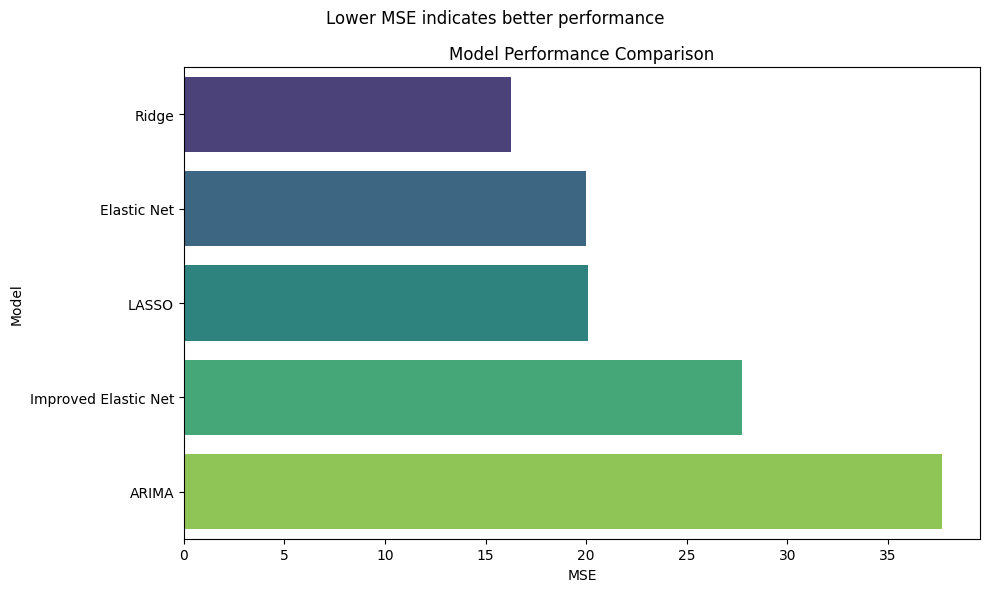

In [36]:
# Create a bar plot for MSE comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=performance_df, x='MSE', y='Model', palette='viridis')
plt.title('Model Performance Comparison')
plt.suptitle('Lower MSE indicates better performance')
plt.tight_layout()
plt.show()

# **DATA VISUALIZATION OF ACTUAL & PREDICTED VALUES**

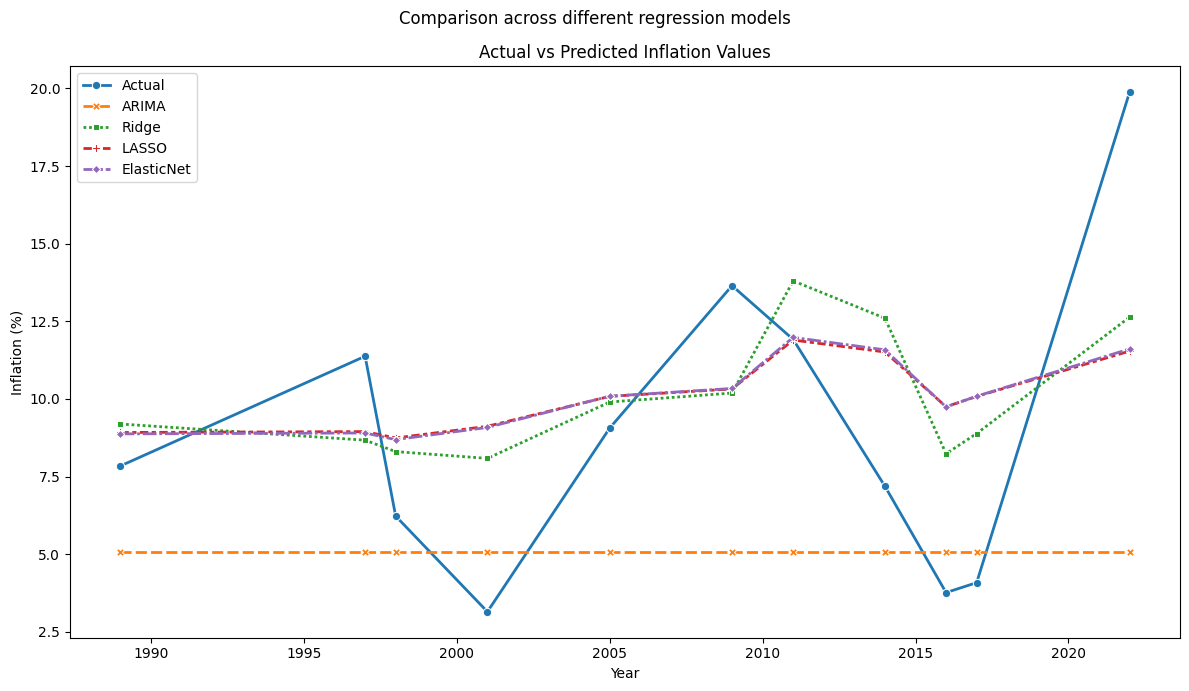

In [37]:
# Create dataframes for plotting (using original test set)
results_df = pd.DataFrame({
    'Time': time_test,
    'Actual': y_test,
    'ARIMA': arima_predictions,
    'Ridge': ridge_predictions,
    'LASSO': lasso_predictions,
    'ElasticNet': elastic_net_predictions
})

# Create a long format for easier plotting
results_long = pd.melt(results_df,
                      id_vars=['Time'],
                      value_vars=['Actual', 'ARIMA', 'Ridge', 'LASSO', 'ElasticNet'],
                      var_name='Model',
                      value_name='Inflation')

# Plot actual vs predicted values
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_long, x='Time', y='Inflation', hue='Model', style='Model', markers=True, linewidth=2)
plt.title('Actual vs Predicted Inflation Values')
plt.suptitle('Comparison across different regression models')
plt.xlabel('Year')
plt.ylabel('Inflation (%)')
plt.legend(title='')
plt.tight_layout()
plt.show()

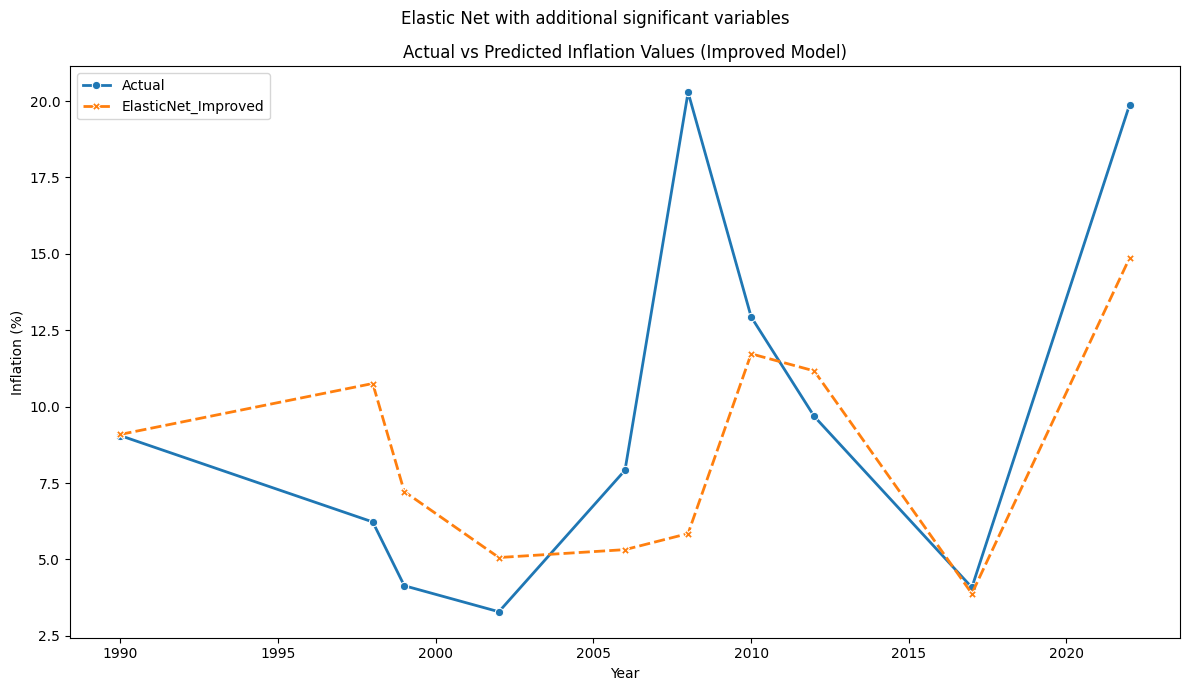

In [38]:
# Plot improved model (with the additional variables)
results_improved_df = pd.DataFrame({
    'Time': time_test_improved,
    'Actual': y_test_improved,
    'ElasticNet_Improved': elastic_net_predictions_improved
})
results_improved_long = pd.melt(results_improved_df,
                               id_vars=['Time'],
                               value_vars=['Actual', 'ElasticNet_Improved'],
                               var_name='Model',
                               value_name='Inflation')
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_improved_long, x='Time', y='Inflation', hue='Model', style='Model', markers=True, linewidth=2)
plt.title('Actual vs Predicted Inflation Values (Improved Model)')
plt.suptitle('Elastic Net with additional significant variables')
plt.xlabel('Year')
plt.ylabel('Inflation (%)')
plt.legend(title='')
plt.tight_layout()
plt.show()

# Residual Analysis:

<Figure size 1400x1000 with 0 Axes>

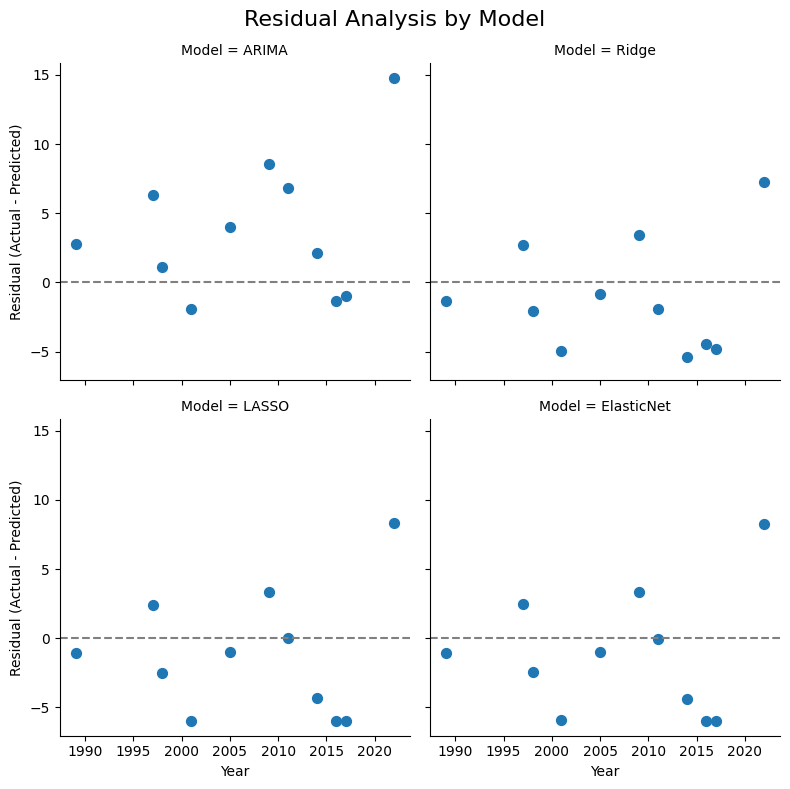

In [39]:
# Calculate residuals for each model
residuals_df = pd.DataFrame({
    'Time': time_test,
    'ARIMA': y_test - arima_predictions,
    'Ridge': y_test - ridge_predictions,
    'LASSO': y_test - lasso_predictions,
    'ElasticNet': y_test - elastic_net_predictions
})
# Convert to long format for plotting
residuals_long = pd.melt(residuals_df,
                        id_vars=['Time'],
                        value_vars=['ARIMA', 'Ridge', 'LASSO', 'ElasticNet'],
                        var_name='Model',
                        value_name='Residual')

# Plot residuals
plt.figure(figsize=(14, 10))
g = sns.FacetGrid(residuals_long, col='Model', col_wrap=2, height=4)
g.map(plt.scatter, 'Time', 'Residual', s=50)
g.map(plt.axhline, y=0, ls='--', color='gray')
g.set_axis_labels('Year', 'Residual (Actual - Predicted)')
g.fig.suptitle('Residual Analysis by Model', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()

# Conclusion:

In [47]:
# Identify the best performing model based on MSE
best_model = performance_df['Model'].iloc[0]
best_mse = performance_df['MSE'].iloc[0]

print(f"The best performing model is {best_model} with an MSE of {best_mse:.4f}\n")

The best performing model is Ridge with an MSE of 16.2504



In [48]:
print("Variable Importance Analysis:")
# For Ridge/LASSO/Elastic Net, examine coefficient magnitudes
if best_model in ["Ridge", "LASSO", "Elastic Net", "Improved Elastic Net"]:
    if best_model == "Ridge":
        best_coef = ridge_model.coef_
        var_names = ['Broad_Money_Growth', 'Crude_Oil_Brent', 'NEER', 'Food_Imports_Pct', 'REER']
    elif best_model == "LASSO":
        best_coef = lasso_model.coef_
        var_names = ['Broad_Money_Growth', 'Crude_Oil_Brent', 'NEER', 'Food_Imports_Pct', 'REER']
    elif best_model == "Elastic Net":
        best_coef = elastic_net_model.coef_
        var_names = ['Broad_Money_Growth', 'Crude_Oil_Brent', 'NEER', 'Food_Imports_Pct', 'REER']
    else:  # Improved Elastic Net
        best_coef = elastic_net_model_improved.coef_
        var_names = var_names_improved


    coef_data = pd.DataFrame({# Extract coefficient values and names
        'Variable': var_names,
        'Coefficient': best_coef
    })

    coef_data['AbsCoef'] = coef_data['Coefficient'].abs()
    coef_data = coef_data.sort_values('AbsCoef', ascending=False)# Sort by absolute coefficient value

    print(coef_data[['Variable', 'Coefficient']])# Print coefficients

    print("\nThe most important variables for predicting inflation in Pakistan are:")
    for i in range(min(3, len(coef_data))):
        if coef_data['Coefficient'].iloc[i] != 0:
            direction = "positive" if coef_data['Coefficient'].iloc[i] > 0 else "negative"
            print(f"{i+1}. {coef_data['Variable'].iloc[i]} with a {direction} effect")

Variable Importance Analysis:
             Variable  Coefficient
3    Food_Imports_Pct     0.136155
1     Crude_Oil_Brent     0.077461
4                REER    -0.024961
2                NEER     0.011392
0  Broad_Money_Growth     0.000937

The most important variables for predicting inflation in Pakistan are:
1. Food_Imports_Pct with a positive effect
2. Crude_Oil_Brent with a positive effect
3. REER with a negative effect


In [49]:
print("\nEconomic Implications:")
print("1. The analysis suggests that understanding the dynamics of inflation in Pakistan requires consideration of multiple economic factors.")

print("2. Both internal factors (like broad money growth) and external factors (like crude oil prices) influence inflation patterns.")

print("3. The importance of exchange rates (NEER/REER) highlights Pakistan's vulnerability to external economic conditions.")

print("4. The potential significance of lagged inflation suggests inflation inertia in the Pakistani economy.")


Economic Implications:
1. The analysis suggests that understanding the dynamics of inflation in Pakistan requires consideration of multiple economic factors.
2. Both internal factors (like broad money growth) and external factors (like crude oil prices) influence inflation patterns.
3. The importance of exchange rates (NEER/REER) highlights Pakistan's vulnerability to external economic conditions.
4. The potential significance of lagged inflation suggests inflation inertia in the Pakistani economy.
